In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x43_DEFG96017_5.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,pub_rec,months_cr_line,term,initial_list_status,grade,sub_grade,emp_length,ANY,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,Not Verified,Source Verified,Verified,loan_status_bin
0,-0.597005,-0.097520,-0.869944,1.946038,1.946038,-0.571645,-0.589946,-0.334080,-0.842890,-0.549725,1.177699,0.409134,-0.313568,-0.074953,-0.152766,-0.432987,-0.880806,-0.250889,1.418967,-0.028990,0.543110,-0.534807,-0.038626,-0.799496,-0.346627,0.997396,-0.130558,-0.228289,-0.729749,3.355633,-0.155008,-0.195661,-0.227385,-0.225567,-0.570326,-0.067003,-0.244110,-0.182995,-0.090892,-0.612791,1.236224,-0.704146,0.0
1,-0.892505,-0.265322,0.853681,0.122264,0.122264,0.615111,-0.825547,-0.732748,-0.928010,-0.442639,0.416292,-0.471800,-0.900815,-0.074953,-0.152766,-0.432987,0.309694,-0.250889,1.418967,1.336607,1.496839,-1.602434,-0.038626,1.250788,-0.346627,-1.002610,-0.130558,-0.228289,1.370333,-0.298006,-0.155008,-0.195661,-0.227385,-0.225567,-0.570326,-0.067003,-0.244110,-0.182995,-0.090892,-0.612791,1.236224,-0.704146,0.0
2,0.324955,-0.082928,1.571316,-0.659353,-0.659353,-0.571645,0.324152,0.263923,0.944622,-0.098814,2.700513,3.051935,-0.900815,-0.074953,-0.152766,0.897184,-0.358444,-0.250889,1.418967,-0.028990,0.543110,-0.534807,-0.038626,1.250788,-0.346627,-1.002610,-0.130558,-0.228289,-0.729749,-0.298006,-0.155008,-0.195661,-0.227385,-0.225567,-0.570326,-0.067003,4.096518,-0.182995,-0.090892,-0.612791,1.236224,-0.704146,1.0
3,-0.466985,-0.236139,1.059649,-0.919892,-0.919892,1.397682,-0.338522,-0.334080,-0.417292,-0.416200,2.700513,0.409134,0.318851,-0.074953,-0.152766,0.897184,-0.564959,-0.250889,1.418967,1.336607,2.132658,-0.000994,-0.038626,1.250788,-0.346627,-1.002610,-0.130558,-0.228289,1.370333,-0.298006,-0.155008,-0.195661,-0.227385,-0.225567,-0.570326,-0.067003,-0.244110,-0.182995,-0.090892,-0.612791,1.236224,-0.704146,1.0
4,0.395875,-0.221547,1.465080,-0.138275,-0.138275,-0.993029,0.357527,0.263923,-0.076814,0.124070,-0.345114,-0.471800,-0.900815,-0.074953,-0.152766,0.897184,1.160051,-0.250889,1.418967,-0.028990,0.225201,1.066632,-0.038626,1.250788,-0.346627,-1.002610,-0.130558,-0.228289,-0.729749,3.355633,-0.155008,-0.195661,-0.227385,-0.225567,-0.570326,-0.067003,-0.244110,-0.182995,-0.090892,-0.612791,-0.808915,1.420160,1.0


In [4]:
data.shape

(2685, 43)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    2084
0.0     601
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(2685, 42)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.78212291 0.77653631 0.77653631 0.76722533 0.78026071]
0.776536312849162


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  24,  577],
       [  23, 2061]])

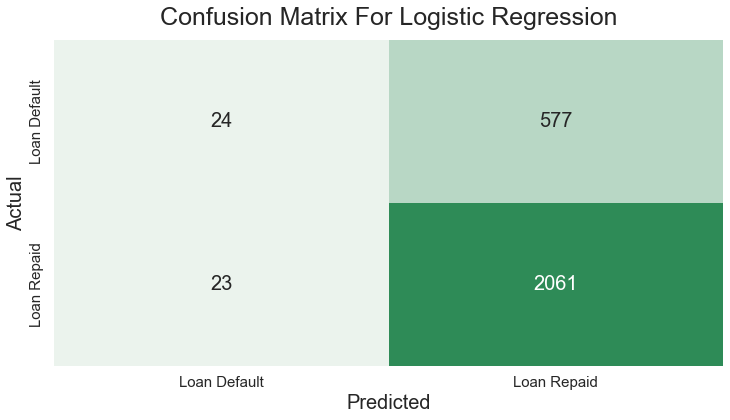

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.776536312849162

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

2061
577
23
24
0.776536312849162


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    2084
0.0     601
Name: loan_status_bin, dtype: int64

0.7761638733705772


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 1% better than Null Model or "random investment"
TP / (TP+FP)

0.7812736921910538

In [17]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [17]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [18]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [19]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.78212291 0.77653631 0.77653631 0.76722533 0.78026071]
0.776536312849162


In [20]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  24,  577],
       [  23, 2061]])

In [21]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [22]:
y_pred_prob

array([[0.32272164, 0.67727836],
       [0.27934528, 0.72065472],
       [0.31804263, 0.68195737],
       ...,
       [0.17534427, 0.82465573],
       [0.28013996, 0.71986004],
       [0.18706295, 0.81293705]])

In [113]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.92).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [114]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 586,   15],
       [1957,  127]])

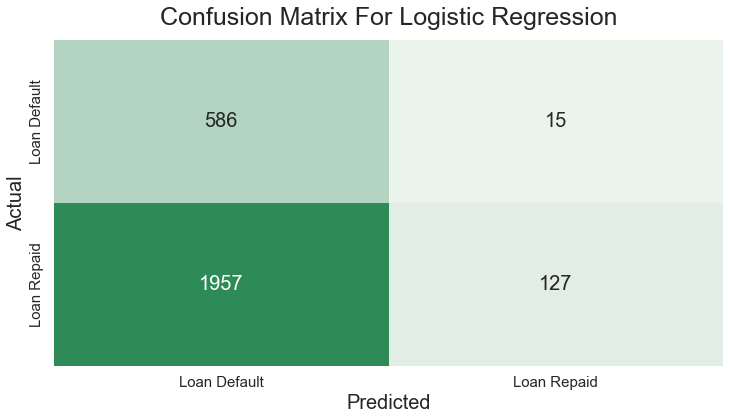

In [115]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [116]:
accuracy_score(y, y_pred_success)

0.2655493482309125

In [117]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

127
15
1957
586
0.2655493482309125


In [118]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8943661971830986

In [143]:
thresh = []
PosPredVal = []

for i in range(0,100,1):
    y_pred_success = (y_pred_prob[:, 1] > (i/100)).astype('float')
    conf_mat = confusion_matrix(y, y_pred_success)
    TN, FP, FN, TP = conf_mat.ravel()
    thresh.append(i)
    PosPredVal.append((TP/(TP+FP)))

print(np.max(PosPredVal))
print(PosPredVal.index(np.max(PosPredVal)))

0.8943661971830986
92


In [30]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [31]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 